In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers




In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
    

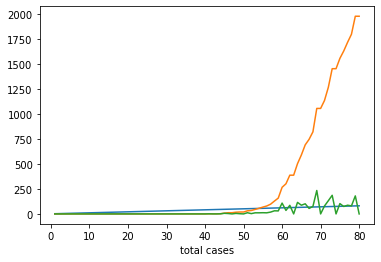

In [52]:
#column_names = ['WC','CH01', 'CH02', 'CH03', 'CH04', 'CH05']
#url="https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019/ccaa_covid19_casos.csv"
url="ds/covid19_confirmed2.csv"

#column_names = ['Andalucia','Aragon','Asturias','Baleares','Canarias', 'Castilla-La Mancha', 'Castilla y Leon', 
#'Cataluna', 'Ceuta', 'C. Valenciana', 'Extremadura', 'Galicia', 'Madrid', 'Melilla', 'Murcia', 'Navarra', 'Pais Vasco', 'La Rioja', 'Total']

raw_dataset = pd.read_csv(url, na_values="?", comment='\t', sep=",", skipinitialspace=True)


dataset = pd.DataFrame(raw_dataset.copy())


#dataset = np.transpose(dataset)
#dataset1 = dataset.iloc[:,6]

#dataset = dataset.drop([dataset.columns[0]],axis='columns')
plt.plot(dataset.iloc[1:])
plt.xlabel('total cases')
plt.show()

#print(dataset1.iloc[:0])
#print(dataset1)


In [53]:
dataset.isna().sum()


Unnamed: 0    0
Argentina     0
frecuencia    0
dtype: int64

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset  = dataset.drop(train_dataset.index)

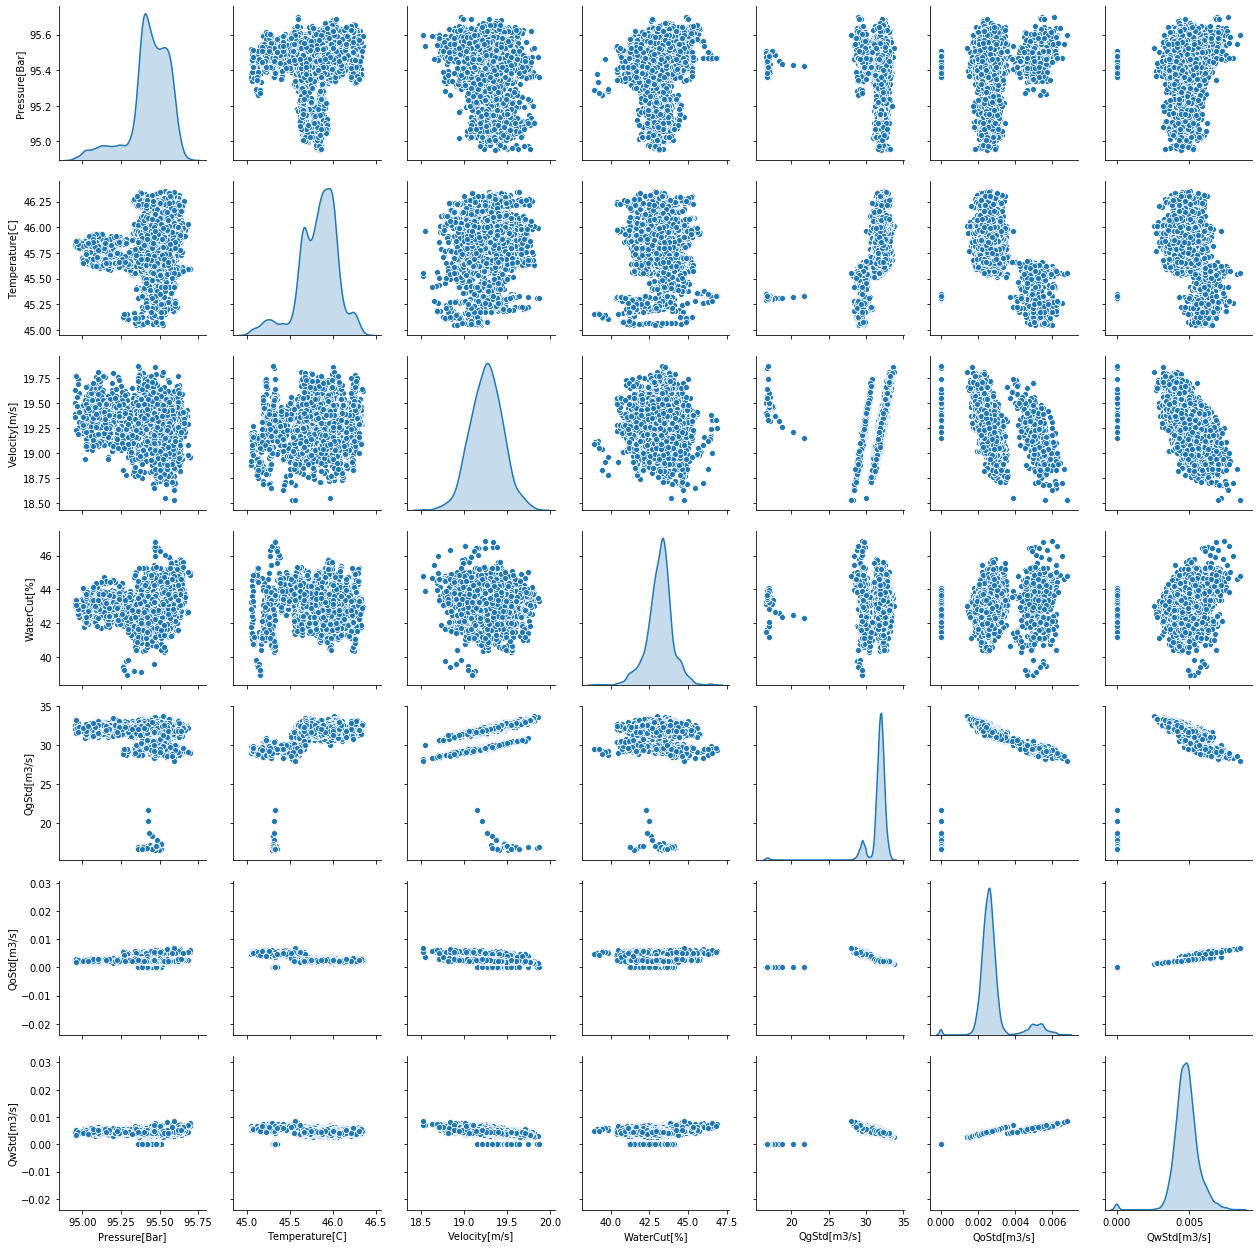

In [12]:
sns.pairplot(train_dataset[["Pressure[Bar]","Temperature[C]","Velocity[m/s]", "WaterCut[%]", "QgStd[m3/s]", "QoStd[m3/s]", "QwStd[m3/s]"]], diag_kind="kde")

In [25]:
train_stats = train_dataset.describe()
train_stats.pop("wc")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
xl,480.0,0.618573,0.021368,0.564257,0.603285,0.620422,0.633712,0.676307
wwc,480.0,63.507725,4.511809,56.931313,59.773320,63.253210,65.667816,77.530273
ch1,480.0,3950.361928,590.160545,2917.386475,3525.894287,3882.457031,4283.842285,6576.618164
ch2,480.0,90.935149,42.416134,25.109913,59.233209,84.690136,113.799547,294.816284
ch3,480.0,3002.170882,698.506034,1771.356445,2487.805176,2924.231201,3397.186035,6108.812988
ch4,480.0,348.057921,88.424574,209.913696,278.373138,337.719360,395.687042,742.818115
ch5,480.0,19.680898,12.225146,2.270285,10.142490,17.962612,26.283530,81.957603


In [26]:
train_labels = train_dataset.pop('wc')
test_labels  = test_dataset.pop('wc')

In [27]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data  = norm(test_dataset)


In [28]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae','mse'])
    return model


In [29]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [37]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[57.675663],
       [65.32713 ],
       [66.753365],
       [63.079926],
       [64.41366 ],
       [58.61998 ],
       [57.16576 ],
       [62.135708],
       [57.091587],
       [62.119984]], dtype=float32)

In [38]:
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split= 0.2, verbose=0,
    callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.9795,  mean_absolute_error:0.7967,  mean_squared_error:0.9795,  val_loss:1.3611,  val_mean_absolute_error:0.9300,  val_mean_squared_error:1.3611,  
....................................................................................................
Epoch: 100, loss:1.1581,  mean_absolute_error:0.8205,  mean_squared_error:1.1581,  val_loss:1.4292,  val_mean_absolute_error:0.9416,  val_mean_squared_error:1.4292,  
....................................................................................................
Epoch: 200, loss:1.1090,  mean_absolute_error:0.8136,  mean_squared_error:1.1090,  val_loss:1.3946,  val_mean_absolute_error:0.9230,  val_mean_squared_error:1.3946,  
....................................................................................................
Epoch: 300, loss:0.9674,  mean_absolute_error:0.7839,  mean_squared_error:0.9674,  val_loss:1.8647,  val_mean_absolute_error:1.1086,  val_mean_squared_error:1.8647,  
..............................

In [39]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.901116,0.740105,0.901116,1.196320,0.846702,1.196320,995
996,0.890349,0.735089,0.890349,1.823487,1.089377,1.823487,996
997,0.989956,0.768074,0.989955,1.530930,0.974353,1.530930,997
998,0.738283,0.677035,0.738283,1.502602,0.986037,1.502602,998
999,1.059318,0.801316,1.059318,1.797747,1.080572,1.797747,999


In [40]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

In [41]:
plotter.plot({'Basic':history}, metric="mae")
plt.ylim([0,10])
plt.ylabel('MAE[wc]')

KeyError: 'mae'

In [35]:
plotter.plot({'Basic':history}, metric="mse")
plt.ylim([0,20])
plt.ylabel('MSE[wc^2]')

KeyError: 'mse'

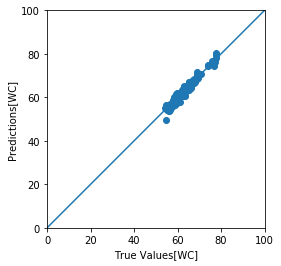

In [42]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values[WC]')
plt.ylabel('Predictions[WC]')
lims = [0,100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [43]:
print(model.predict(normed_test_data[:1]))

print((normed_test_data.iloc[9,:]).shape)

(normed_test_data[:1]).shape

[[76.30699]]
(7,)


(1, 7)

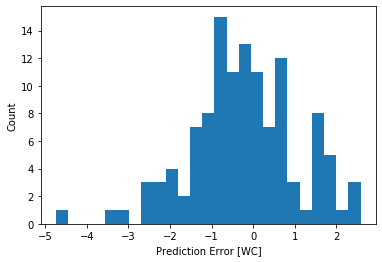

In [44]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [WC]")
_ = plt.ylabel("Count")